# Data preparation
In this section of the course, we will cover the necessary steps for preparing the data for training a Pix2Pix model for breast lesion synthesis given an arbitrary lesion mask. Specifically, we will cover:

1. Loading of images and corresponding masks and curating them
2. Extraction of the region of interest from the masks
3. Saving of the preprocessed images for use in the next parts of the course.

By the end of this section, you will have a solid understanding of the data preparation process and the role it plays in training a successful image synthesis model. We will be using the `torchio` library for loading, processing the images. Let's get started!

### Imports and constants
Let's first import all the python libraries that are necessary to do the tasks described above.

**NOTE** You are given a data loader to speed up the process. It is recommended to go through it on your own time and contact your tutor if you have particular questions regarding the implementation of the loader. This loader class has been prepared specifically for the public Breast Cancer Digital Repository (BCDR) dataset that contains Full-Field Digital and Scanned Film Mammograms (MGs) with corresponding lesion masks.

In [2]:
import matplotlib
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchio as tio
from pathlib import Path
from typing import Tuple
from bcdr_loader import load_dataset, get_subjects_with_nodules, BCDRDataset

**NOTE** As you can see, we will be using the `torchio` library to handle our data. In summary:
- It is an open-source python library for loading, preprocessing, augmenting, and saving medical images.
- It is built on top of PyTorch and provides a high-level API for image processing.
- It can handle images with multiple modalities, labels, and different types of data (CT, MRI, microscopy, etc.).
- It has functionalities for data augmentation specific to medical imaging such as elastic deformation, bias field correction, or intensity normalization.

Specifically, in this course, we will be using the `data structure` and `preprocessing` features of torchio.
For more details have a look at the documentation [here](https://torchio.readthedocs.io/)

Now, let's go ahead and load the BCDR images into our workspace. To do that, we first have to call the `load_dataset` function with the following variables:
- `path`: path to the dataset folder
- `outlines_csv`: path to the csv file with outline coordinates of the lesions

BCDR comes in different folders as the dataset was released in different batches. We define these three variables here for you.

In [2]:
# Modify the BCDR_DATASET_DIR to point to the location of the BCDR dataset
BCDR_DATASET_DIR = Path('/home/kaisar/Documents/courses/BigDataSchoolAfrica/dataset/BCDR')
BCDR_PATH =  [BCDR_DATASET_DIR / 'BCDR-D01_dataset',
              BCDR_DATASET_DIR / 'BCDR-D02_dataset',
              BCDR_DATASET_DIR / 'BCDR-F01_dataset',
              BCDR_DATASET_DIR / 'BCDR-F02_dataset',
              BCDR_DATASET_DIR / 'BCDR-F03_dataset/BCDR-F03']
# We specify the following outlines files to be able to extract the segmentation masks for the lesions
BCDR_OUTLINES_CSV =  [BCDR_DATASET_DIR / 'BCDR-D01_dataset/bcdr_d01_outlines.csv',
                      BCDR_DATASET_DIR / 'BCDR-D02_dataset/bcdr_d02_outlines.csv',
                      BCDR_DATASET_DIR / 'BCDR-F01_dataset/bcdr_f01_outlines.csv',
                      BCDR_DATASET_DIR / 'BCDR-F02_dataset/bcdr_f02_outlines.csv',
                      BCDR_DATASET_DIR / 'BCDR-F03_dataset/BCDR-F03/bcdr_f03_outlines.csv']
# Let's also define our constant RANDOM_SEED for reproducibility
RANDOM_SEED = 32

### Data loading
Let's load the subjects and take a look what the **pandas** `DataFrame` returns!

In [3]:
df = load_dataset(BCDR_PATH, BCDR_OUTLINES_CSV)
# Print number of unique patient_ids in the data frame
print(f'BCDR ---- TOTAL NUMBER OF SAMPLES: {df.shape[0]}')
df.head(5)

BCDR ---- TOTAL NUMBER OF SAMPLES: 1884


,scan,mask,pathology,classification,patient_id,laterality,view,age,ACR,study_id,lesion_id
0,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,"[nodule, architectural_distortion]",Malign,3,LEFT,CC,74,1,4,7
1,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,"[nodule, architectural_distortion]",Malign,3,LEFT,MLO,74,1,4,7
2,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,"[nodule, calcification]",Benign,4,LEFT,MLO,59,3,8,9
3,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,"[nodule, calcification]",Benign,4,LEFT,CC,59,3,8,9
4,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,[nodule],Benign,5,LEFT,CC,64,1,10,11


As you can see, we have now a table with some interesting columns. Let's dive in into each of the columns that we are going to use in this project:
- `scan`: absolute path to the MG image
- `mask`: absolute path to the segmentation mask that corresponds to that MG image
- `pathology`: defines what type of abnormality that mask represents
- `patient_id`: This is a uniqe identifier of that patient

The rest of the columns are: 
- `classification`: defines if the pathology is benign or malignant
- `laterality`: left or right breast
- `view`: view of the MG projection
- `age`: patient's age
- `ACR`: breast density
- `study_id` and `lesion_id`: unique identifiers for the MG scan and that specific lesion

**Note** An MG study usually contains 4 images per patient. Two views -- Craniocaudal (CC) and MedioLateral Oblique (MLO) -- more or less orthogonal projections of the compressed breast. CC is top to bottom, and MLO from side to side. And two more images that correspond to the Left and Right breasts. Note that for patients that underwent mastectomy (removal of the whole breast) one study may include MG series of only one breast, i.e. two views of a single breast.

#### Curation
As you can see, the `pathology` column contains multiple types of lesions. In this project, we want to synthesise breast masses -- or **nodules** as defined in our dataset. We provide a function that extracts lesions that contain `nodule`s. Note that one lesion may be assosiated with different pathologies, but we only want to have `nodule`s. We drop the rows that contain other pathologies. For example, rows that we remove can be `['nodule', 'calcification']` or `['architectural_distortion', 'nodule']`, or `['calcification']` or `['architectural_distortion', 'calficiation']`. We only keep rows that have only `['nodule']`.

To accomplish this, simply run the next cell. *If you're interested how it's done, check the function in the `bcdr_loader.py` file.*

In [4]:
df = get_subjects_with_nodules(df)
df.head(10)

,scan,mask,status,patient_id,laterality,view,study_id,lesion_id,pathology
0,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,5,LEFT,CC,10,11,[nodule]
1,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,5,LEFT,MLO,10,11,[nodule]
2,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,5,LEFT,MLO,9,13,[nodule]
3,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,5,LEFT,CC,9,13,[nodule]
4,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,8,RIGHT,MLO,16,18,[nodule]
5,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,8,RIGHT,MLO,844,19,[nodule]
6,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,8,RIGHT,MLO,15,21,[nodule]
7,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,12,RIGHT,MLO,20,24,[nodule]
8,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,12,RIGHT,CC,20,24,[nodule]
9,/home/kaisar/Documents/courses/BigDataSchoolAf...,/home/kaisar/Documents/courses/BigDataSchoolAf...,0,511,LEFT,CC,734,27,[nodule]


As you can see, the pathology column now only contains cases with `nodule`s or `masses`.

#### Data splitting
Now, let's split the data into training, validation, and testing sets.

**IMPORTANT** We must make sure that there are no overlaps between these sets otherwise our model will suffer from ***Data Leakage*** which we should avoid to be fair in our evaluation! To do this, we can use the `patient_id` as we said it is a **unique** identifier per patient. If we make sure that no MG images of the same patient ends up in the same set, then we are safe!

**NOTE** When you work with other datasets, make sure that these unique identifiers are indeed unique!

**TASK #1**
Complete the function below to split our `DataFrame` into `train`, `validation`, and `test` sets with a given proportion and make sure that there are no overlaps of `patient_id`s in these three sets.

In [5]:
# Add necessary imports here
from sklearn.model_selection import GroupShuffleSplit
def unique_group_train_val_test_split(df: pd.DataFrame,
                                      ratio_train: float,
                                      ratio_val  : float,
                                      ratio_test : float) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''TODO
    1) (Optional) Replace this comment with a short documentation with explanation of what it does and what
    are the accepted arguments and their formats
    2) Implement the function as described in the description of the TASK#1
    HINT: use GroupShuffleSplit function from sklearn.model_selection library. Add imports as necessary.
    '''
    # let's make sure that ratio_train, ratio_val, and ratio_test add up to 1 and they are non-zero.
    assert ratio_train > 0. and ratio_val > 0. and ratio_test > 0., "All ratios must be non-zero"
    assert ratio_train + ratio_val + ratio_test == 1.0, "Given splits don't add up to one"
    # <YOUR CODE HERE>
    return None, None, None

Now, let's test your solution!

In [6]:
'''
call the split function that you just defined
we pass our DataFrame df that we loaded earlier and split the it into
train val test with 0.8, 0.1, and 0.1 proportions
'''
df_train, df_val, df_test = unique_group_train_val_test_split(df, 0.9, 0.05, 0.05)
print(f'SPLITS ---- {df_train.shape[0]} TRAINING, {df_val.shape[0]} VALIDATION, {df_test.shape[0]} TESTING')

# 1. Let's make sure you didn't miss any samples!
assert df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0], 'Oops, you lost some samples'
# 2. Let's make sure there are no overlaps between train and val sets using set intersection
assert set(df_train['patient_id']).intersection(set(df_val['patient_id'])) == set(), 'Oops, there are overlaps between train and val sets'
# 3. Let's make sure there are no overlaps between train and test sets
assert set(df_train['patient_id']).intersection(set(df_test['patient_id'])) == set(), 'Oops, there are overlaps between train and test sets'
# 4. Let's make sure there are no overlaps between val and test sets
assert set(df_val['patient_id']).intersection(set(df_test['patient_id'])) == set(), 'Oops, there are overlaps between val and test sets'
print('All tests passed!')

SPLITS ---- 609 TRAINING, 30 VALIDATION, 28 TESTING
All tests passed!


#### Custom dataset
If you passed all the test, let's move on to load declare our Dataset!

We have provided you with a custom PyTorch `Dataset` -- `BCDRDataset`. This class accepts a `DataFrame` and `transforms` as arguments. The `transforms` is optional, but if we skip it, the images will be loaded as they are. Let's first try it without any transforms. We will define the transforms later on.

Click [here](https://torchio.readthedocs.io/data/subject.html) to learn more about `torchio` data structures.

In [7]:
# We'll use val_df to test our loader
val_dataset = BCDRDataset(df_val, transform=None)
# Let's take a look at the first sample!
sample = val_dataset[0]
print(sample.keys())

dict_keys(['scan', 'mask', 'status', 'patient_id', 'laterality', 'view', 'study_id', 'lesion_id', 'pathology'])


As you can see, the `sample` variable is a `dictionary` that contains the same `keys` as our data frame.

Let's see what are the data types of each key-value pairing

In [8]:
print(f'Data type of the sample is {type(sample)}')
for key, value in sample.items():
    print(f'Key: {key}, Value type: {type(value)}')

Data type of the sample is <class 'torchio.data.subject.Subject'>
Key: scan, Value type: <class 'torchio.data.image.ScalarImage'>
Key: mask, Value type: <class 'torchio.data.image.LabelMap'>
Key: status, Value type: <class 'str'>
Key: patient_id, Value type: <class 'str'>
Key: laterality, Value type: <class 'str'>
Key: view, Value type: <class 'str'>
Key: study_id, Value type: <class 'str'>
Key: lesion_id, Value type: <class 'str'>
Key: pathology, Value type: <class 'str'>


We can see that that all columns are of type python `str`, except for `scan` and `mask`, which are `ScalarImage` and `LabelMap` from the `torchio` data format, respectively.

These types are quite simple, below you can see that they are `dictionaries` in essence, but with a little convenience.

In [9]:
scan = sample['scan']
mask = sample['mask']
print(f'Shape of the scan is {scan.shape}')
print(f'Shape of the mask is {mask.shape}')
# we can access the data from the scan and the mask
scan_data = scan.data
mask_data = mask.data
print(f'Shape of the scan data is {scan_data.shape}')
print(f'Shape of the mask data is {mask_data.shape}')

Shape of the scan is (1, 4084, 3328, 1)
Shape of the mask is (1, 4084, 3328, 1)
Shape of the scan data is torch.Size([1, 4084, 3328, 1])
Shape of the mask data is torch.Size([1, 4084, 3328, 1])


Do you see the difference between two ways of printing the data shapes? That's right, the first two lines printed the shapes of the loaded images, and the second two lines are showing the type as `torch.Size()`. We can see that calling `scan.data` extracted `torch.Tensor` objects! Let's plot them, shall we?

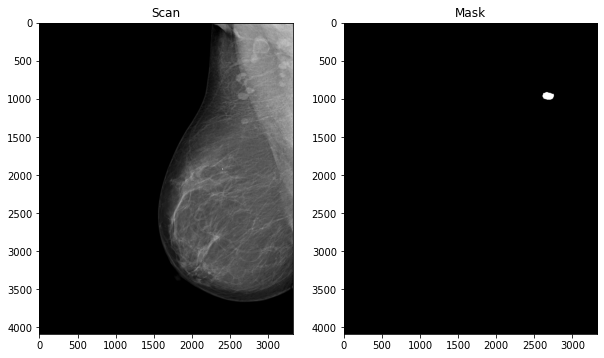

In [10]:
# Let's plot the scan and the mask side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(scan_data[0], cmap='gray')
ax[0].set_title('Scan')
ax[1].imshow(mask_data[0], cmap='gray')
ax[1].set_title('Mask')
plt.show()

You may have noticed the weird shapes of these images: (1, 4084, 3328, 1).
This particular shape means the following:
(Channels, Height, Width, Depth) or (C, H, W, D)

The MG images are grayscale, meaning that the number of channels is 1.
And they are of extremely high resolution (micrometer), meaning that the dimensionality or the number of pixels is extremely high (3K to 4K).
Moreover, the MG image is a projection of a breast onto 2D matrix, hence, the depth is 1.

**NOTE** When we define our neural network, we set it to accept 2D images: the input shape will be (Batch size, Channels, Height, Width). Therefore we will need to remove the Depth dimension when training (we will get to this later in the course).

### Preprocessing and ROI extraction

We have seen that our MG images are very large (4K) images and from the mask we can see that the mass (white blob in the image on the right) is very small relative to the size of the image. In this project, we want to generate synthetic masses, but before doing so we need to perform some preprocessing steps:

1) Find the left-top and right-bottom coordinates of a rectangle (or bounding-box) so that the whol lesion resides inside that rectangle. We will use the `mask` to do this.
2) Crop this bounding-box into a square Region of Interest (ROI) from both the `scan` and the `mask`. We need to be **careful** with the lesions that are near the boundaries of the MG. **Note** that this bounding-box will be tight to the boundaries of the lesion. We want the lesion to be loose a litle in the patch. Therefore, make sure to add a little `pad` when cropping the patch.
3) Resize the ROI into a homogenious shape, e.g. (128x128 or 256x256 pixels)
4) Perform some intensity adjustments such as histogram equalisation, normalisation, etc. **NOTE** We will skip this step in this part of the course because we first will save the ROIs as small `png` patches to make the loading and training faster for the image synthesis GAN. This step will be performed in GAN training.

We will define these steps (except for 4) as `torchio.transforms`. The complete list of existing transforms can be found [here](https://torchio.readthedocs.io/transforms/transforms.html#transforms-api)

#### Manual extraction

**TASK #2** Complete the function `get_bounding_box` below to achieve the result described in step 1.

**TASK #3** Complete the function `crop_scan_and_mask` below to achieve the result described in steps 2 and 3.

In [3]:
# Step 1: Find the left-top and right-bottom corners of the bounding box given a mask
def get_bounding_box(mask: torch.Tensor) -> Tuple[Tuple[int, int], Tuple[int, int]]:
    '''
    TODO
    1) (Optional) Replace this comment with a short documentation with explanation of what it does and what
    are the accepted arguments and their formats
    2) Implement the function as described in the description of the TASK#2
    HINT: use np.where function to find the indices of the non-zero elements in the mask
    '''
    # <YOUR CODE HERE>
    # Solution:
    return None, None

# Step 2: Crop the scan and the mask given the bounding box. Note that the bounding box is rectangular and we need a square
def crop_scan_and_mask(scan: torch.Tensor,
                       mask: torch.Tensor,
                       left_top: Tuple[int, int],
                       right_bottom: Tuple[int, int],
                       size: Tuple[int, int],
                       bbox_padding: int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    TODO
    1) (Optional) Replace this comment with a short documentation with explanation of what it does and what
    are the accepted arguments and their formats
    2) Implement the function as described in the description of the TASK#3
    HINT: use torch.index_select function to crop the scan and the mask
    HINT: use F.interpolate to resize the scan and the mask to the desired size. Use mode='bilinear' and mode='nearest' for scan and mask respectively.
    '''
    # <YOUR CODE HERE>
    # Solution:
    # return None, None

Let's test both functions with the `sample` that we defined earlier and plotted.

Left-top corner of the bounding box is (917, 2600)
Right-bottom corner of the bounding box is (1016, 2750)


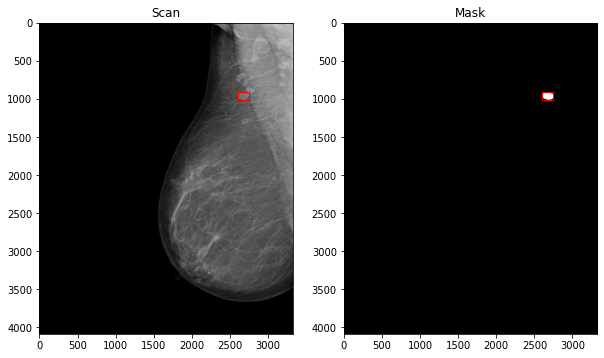

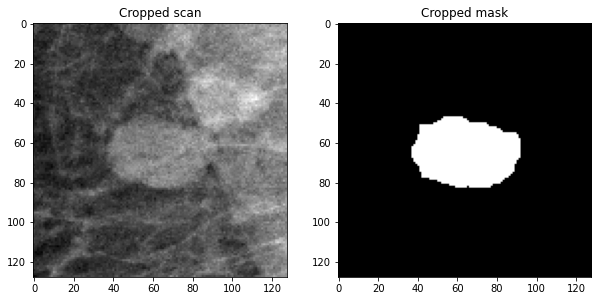

In [12]:
# Get the bounding box
left_top, right_bottom = get_bounding_box(mask)
print(f'Left-top corner of the bounding box is {left_top}')
print(f'Right-bottom corner of the bounding box is {right_bottom}')
# Plot the bounding box on the scan and on the mask
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# defined new left_top and right_bottom to account for matplotlib's coordinate system
mpl_left_top = (left_top[1], left_top[0])
mpl_right_bottom = (right_bottom[1], right_bottom[0])
ax[0].imshow(scan_data[0], cmap='gray')
ax[0].set_title('Scan')
ax[0].add_patch(patches.Rectangle(mpl_left_top, mpl_right_bottom[0] - mpl_left_top[0], mpl_right_bottom[1] - mpl_left_top[1], linewidth=1, edgecolor='r', facecolor='none'))
ax[1].imshow(mask_data[0], cmap='gray')
ax[1].set_title('Mask')
ax[1].add_patch(patches.Rectangle(mpl_left_top, mpl_right_bottom[0] - mpl_left_top[0], mpl_right_bottom[1] - mpl_left_top[1], linewidth=1, edgecolor='r', facecolor='none'))
plt.show()

# Crop the scan and the mask
crop_scan, crop_mask = crop_scan_and_mask(scan_data, mask_data, left_top, right_bottom, size=(128, 128), bbox_padding=100)
# Plot the cropped scan and the mask
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(crop_scan, cmap='gray')
ax[0].set_title('Cropped scan')
ax[1].imshow(crop_mask, cmap='gray')
ax[1].set_title('Cropped mask')
plt.show()

If everythign went successfull, you should see outputs like these (maybe not exactly the same), the first one being bounding box around the lesion and second is the cropped centered lesion.

![bbox](images/example_bbox.png)

![roi](images/example_roi.png)

#### ROI extraction with torchio
Well done if you have completed the tasks 2 and 3! If not, do not worry, you can spend more time later to do this manually. I encourage you to spend time on this to understand the matrices and dimensions. But for now, let's go ahead and use an existing method from the `torchio` library. Yes, these functions are already implemented in `torchio` and have been tested.

Torchio uses `transforms` to accomplish these tasks. Let's now define the transforms that we will use.

In [13]:
# Steps 2 and 3 using torchio
roi_extractor = tio.CropOrPad((128, 128, 1), mask_name='mask')
sample_roi = roi_extractor(sample)

It's simple as that! Let's dissect it a little.

`tio.CropOrPad` is a `transform` function that returns a `Callable` function. First we need to define the transforms. That's what we are doing in the first line. We specify the crop size as `(128, 128, 1)`, where the last dimension is 1 because, as we said, MGs are 2D and the depth is 1. The second argument is `mask_name`, where we tell `CropOrPad` function to look at the `mask` key in the `Subject` sample.

Remeber the keys? `dict_keys(['scan', 'mask', 'status', 'patient_id', 'laterality', 'view', 'study_id', 'lesion_id', 'pathology'])`? We are storing the lesion segmentation mask under the `mask` key and we tell `CropOrPad` to focus around that segmentation mask by setting `mask_name='mask'`

Once we declared it, now the `roi_extractor`, as we called it, is a function that accepts `Subject` sample as an input. Torchio handles the dimension of the minibatches, so we can send multiple samples at the same time! Convenient, isn't it?

That's the second line, where we transform our `sample` and get `sample_roi`, which is now the cropped version of the same image around the mask with the shape that we specified. Let's plot it and see.

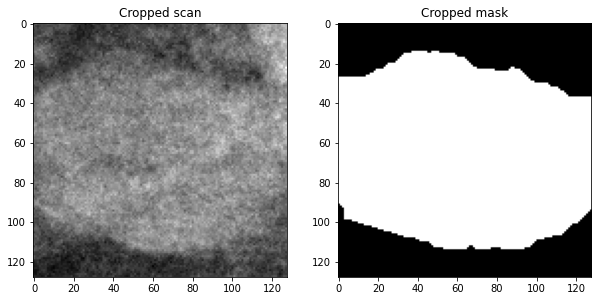

In [14]:

# There are two ways of accessing the Tensor data stored in the tio.Subject object
# 1) thinking of it as a dictionary (which in essence is very similar to a Python dictionary)
crop_scan = sample_roi['scan']['data']
crop_mask = sample_roi['mask']['data']
# 2) or as we did in the very beginning, through ".data"
crop_scan = sample_roi['scan'].data
crop_mask = sample_roi['mask'].data
# Plot the cropped scan and the mask
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(crop_scan[0], cmap='gray')
ax[0].set_title('Cropped scan')
ax[1].imshow(crop_mask[0], cmap='gray')
ax[1].set_title('Cropped mask')
plt.show()

**NOTE** There is one thing that `tio.CropOrPad` doesn't do for us. You may have noticed that the lesion now is not fully visible. This is because `CropOrPad` does not take into account the scale of the image. It only makes sure that the extracted patch or ROI is centred around the `mask_name` and crops it to a given shape.

Look at these examples, where we set the patch size to be (256, 256, 1) and (128, 128, 1):

![256](images/croporpad256.png)

![128](images/croporpad128.png)

Can you see the issue?

Now, let's fix it so that the lesion is at the centre with some margin. We can follow the following steps:

1. Find the lesion size
2. Resize the whole MG so that the new lesion size fits our patch size (e.g. 128x128 pixels)
3. Convert this function into a custom `transform`
4. Call this function before `tio.CropOrPad`

Hey, we already have the solution to step 1! Let's use that=) Don't worry if you couldn't get it done before, I'll give you the solution here below.

In [15]:
# Solution to step 1
# def get_bounding_box(mask: torch.Tensor) -> Tuple[Tuple[int, int], Tuple[int, int]]:
# Notice that we are changing the name of the function and the return type to calculate only the maximum dimension of the lesion
def get_lesion_size(mask: torch.Tensor) -> int:
    # find the indices of the non-zero elements in the mask
    indices = np.where(mask)
    # find the left-top and right-bottom corners of the bounding box
    left_top = (np.min(indices[1]), np.min(indices[2]))
    right_bottom = (np.max(indices[1]), np.max(indices[2]))
    # return left_top, right_bottom
    # we only need the size of the max dimension
    lesion_size = max(right_bottom[0] - left_top[0], right_bottom[1] - left_top[1])
    return lesion_size

Now, I'll leave the steps 2, 3, and 4 to you. I'll leave some hints to help you solve it.

In [16]:
# Task 2 and 3: Custom transform that accepts lesion size and patch size and returns a resized image so that the lesion fits in the patch
class ResampleToLesion(object):
    def __init__(self, patch_size: int):
        self.patch_size = patch_size

    def get_lesion_size(self, mask: torch.Tensor) -> int:
        # find the indices of the non-zero elements in the mask
        indices = np.where(mask)
        # find the left-top and right-bottom corners of the bounding box
        left_top = (np.min(indices[1]), np.min(indices[2]))
        right_bottom = (np.max(indices[1]), np.max(indices[2]))
        # return left_top, right_bottom
        # we only need the size of the max dimension
        lesion_size = max(right_bottom[0] - left_top[0], right_bottom[1] - left_top[1])
        return lesion_size

    def __call__(self, sample: tio.Subject) -> tio.Subject:
        # Get the mask from the sample
        mask = sample['mask'].data
        # Get the lesion size
        lesion_size = self.get_lesion_size(mask)
        # <YOUR CODE HERE>
        # HINT 1: use tio.Resample. You can define it the same way as we did for the roi_extractor
        return sample


Let's call your fresh custom transform and test it with different patch sizes!

Patch size: 64


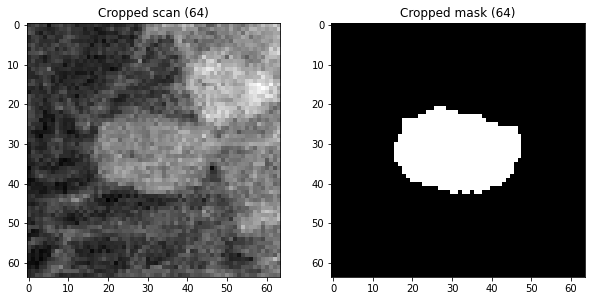

Patch size: 128


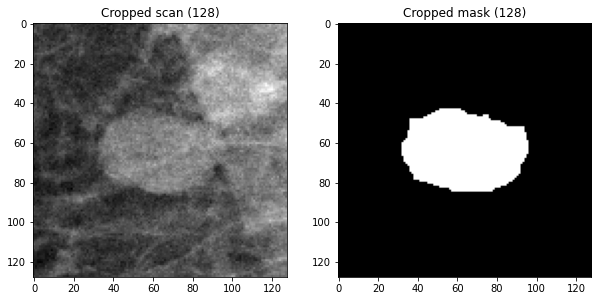

Patch size: 256


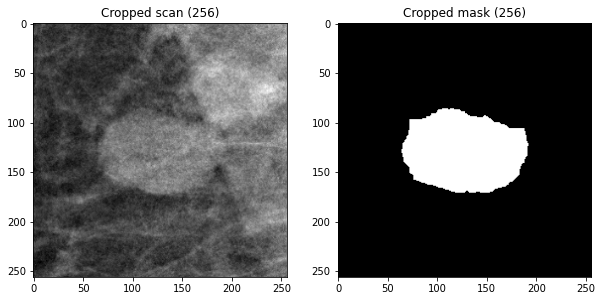

In [17]:
# Let's test the transform for different patch sizes
for patch_size in [64, 128, 256]:
    print(f'Patch size: {patch_size}')
    # Define the transform
    transforms = tio.Compose([
        ResampleToLesion(patch_size=patch_size),
        tio.CropOrPad((patch_size, patch_size, 1), mask_name='mask'),
    ])
    # Apply the transform
    sample_roi = transforms(sample)
    # Plot the cropped scan and the mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(sample_roi['scan'].data[0], cmap='gray')
    ax[0].set_title(f'Cropped scan ({patch_size})')
    ax[1].imshow(sample_roi['mask'].data[0], cmap='gray')
    ax[1].set_title(f'Cropped mask ({patch_size})')
    plt.show()

Well done! Now, whatever patch size we give, the lesion is always centred! One thing that may be new here is `tio.Compose`. If you're familiar with PyTorch, it is exactly the same as the `torchvision.transforms.Compose`, which calls all the specified transforms one after another.

**NOTE** This solution to extract ROIs works for us, but it's not the most *efficient* one. If you plug this code to extract ROIs on the fly during training, it will become the bottleneck and slow down your training. This code, or the whole logic of extracting patches can be done much more efficiently that can be included in the training process directly as it won't slow down the training. I leave it to you as a challenge for the future!

### Saving the extracted patches/ROIs
We have come so far, but before we finish this part, let's extract all the masses from our dataset into a convenient format that we will use in the next part of the course. We will use our custom transforms that we wrote earlier. Let's go ahead and define the steps again:

1. Define the BCDR datasets for train, validation, and test the same way we did before to test our solutions using `val_df`, but pass the `transforms` that we defined as the second argument. For example, `val_dataset = BCDRDataset(val_df, transforms=transforms)`.
2. Loop through each dataset and save the image and mask in the following folder structure:
   ```
   |patches/
   |----|train/
   |----|----|1_scan.png
   |----|----|1_mask.png
   |----|----|*_scan.png
   |----|----|*_mask.png
   |----|----|N_scan.png
   |----|----|N_mask.png
   |----val/
   |----|----|1_scan.png
   |----|----|1_mask.png
   |----|----|*_scan.png
   |----|----|*_mask.png
   |----|----|N_scan.png
   |----|----|N_mask.png
   |----test/
   |----|----|1_scan.png
   |----|----|1_mask.png
   |----|----|*_scan.png
   |----|----|*_mask.png
   |----|----|N_scan.png
   |----|----|N_mask.png
   ```

**NOTE** You don't need to call `transforms` again inside the loop, because we passed the `transforms` to the `BCDRDataset`. This will already apply these transforms and return extracted patches. We only need to loop through and save them in the format as shown above.

In [18]:
# Let's first difine it for test set and I'll leave it to you to define it for the training and validation sets
patch_size = 128
transforms = tio.Compose([
    ResampleToLesion(patch_size=patch_size),
    tio.CropOrPad((patch_size, patch_size, 1), mask_name='mask'),
])
# lets define the test dataset
test_dataset = BCDRDataset(df_test, transforms)
# let's create the folder `patches` and `test` subfolder to save the extracted ROIs
# use pathlib's Path to handle this
patches_folder = Path('patches')
test_folder = patches_folder / 'test'
test_folder.mkdir(parents=True, exist_ok=True)
# let's use tqdm to show the progress bar (but this is not necessary)
from tqdm import tqdm
for i, sample in enumerate(tqdm(test_dataset)):
    # note here that `sample` is already an extracted patch, we only need to save it
    # we will save the images and the masks in the `test` folder
    scan = sample['scan'].data.squeeze()
    mask = sample['mask'].data.squeeze()
    # save both the scan and the mask as png images
    # use the i as a counter to name the images
    scan_path = test_folder / f'{i+1}_scan.png'
    mask_path = test_folder / f'{i+1}_mask.png'
    # we will use matplotlib's imsave to save the images
    plt.imsave(scan_path, scan, cmap='gray')
    plt.imsave(mask_path, mask, cmap='gray')

100%|██████████| 28/28 [00:05<00:00,  5.60it/s]


Now it's your turn to do this for `train` and `val` sets!

In [19]:
# <YOUR CODE HERE> no hints here, you can do it!

100%|██████████| 30/30 [00:03<00:00,  8.19it/s]


### Conclusions and next steps
Congrats for completing this part! I hope you got to learn new things and understand the importance of data curation and preparation. Most of the time, when working with big data, it's not training models, but curating and cleaning the data for your needs. Clean data in less amounts, especially in medical imaging, is more useful than dirty data, sort of speak, in big amounts.

Notice that after data curation, we've got only 553 samples for training? That seems very small amount and yes it is indeed. However, in medical imaging, that is all in a days work. In the next part of the course, we will dive into overcoming the data scarcity to increase the amount of training samples. Not only by the means of traditional data augmentation as flipping, rotating, and mirroring, but using more information that this specific dataset gives us. Let's now move on to the next part where we get our hands dirty one more time to prepare our ROIs for GAN training!